In [7]:
import numpy as np
import matplotlib.pylab as plt
np.set_printoptions(precision=2)
import warnings
warnings.filterwarnings('ignore')

# Přednáška 1: Základy a specifika bayesovské teorie

**Obsah přednášky**
- Základy a specifika bayesovské teorie - neurčitost, vývoj znalosti, typy odhadů, metody.
- Zavedení pojmů machine learning a bayesovství (zatím vágně)
- Apriorní znalost a její kvantifikace distribucí
- Aposteriorní znalost coby apriorno aktualizované daty (měřeními, pozorováními)
- Teoretická možnost sekvenčního updatu apost -> apriorno -> aposteriorno -> apriorno…
- Data popisuje model (připouštíme nepřesnost modelu)
- Update dělá Bayesova věta - k tomu potřebujeme trochu matematiky
  - distribuce psti, hustota psti (diskrétní a spojitý případ)
  - jedno a vícerozměrné případy (hustoty, nezávislost na pořadí proměnných)
  - marginalizace
  - řetězové pravidlo
  - Bayesova věta
- rozhodovací stromy
- Problémy s odvozením aposteriorna
  - někdy to jde analyticky (příští přednáška)
  - někdy se musí aproximovat (VB, Monte Carlo, MCMC…)
- Typy odhadů
  - Bodové odhady - co zvolit? Střední hodnota, medián, modus…
  - Intervalové odhady - credibility intervaly (highest probability region) vs. frekventistické odhady
  - Konzistence odhadu (vágně)
- Stručné srovnání s frekventismem
  - rozdíl je ve filosofii, OK jsou oba přístupy


## Příklady jako motivace

### Mince

*Házíme mincí a zajímá nás pravděpodobnost, že padne jedna nebo druhá strana (panna nebo orel, rub či líc). Je naše mince férová?*

Označíme 1 jako rub a 0 jako líc. Pokud bychom postupovali klasicky, vezmeme minci, budeme s ní házet a výsledky zaznamenávat do tabulky (matice). Posléze můžeme vykreslit histogram (_plt.hist()_), který zde nahradíme z pragmatického důvodu trochu jiným typem grafu. Házení mincí za nás obstará funkce *np.random.randint()*, která náhodně (a rovnoměrně - ale to budeme dělat že nevíme :-)) vzorkuje celá čísla z daného intervalu.

Líc: 38 (0.38)
Rub: 62 (0.62)


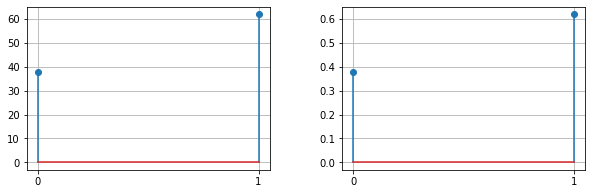

In [8]:
nsamples = 100 ### ("###" budeme značit parametry s nimiž lze experimentovat a sledovat výsledky)
results = np.random.randint(0, 2, size=nsamples)
counts = np.array([results.sum(), nsamples - results.sum()])
frequences = counts/nsamples
print('Líc: {0} ({1:.2})'.format(counts[0], frequences[0]))
print('Rub: {0} ({1:.2})'.format(counts[1], frequences[1]))
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.stem(counts)
plt.xticks([0, 1])
plt.subplot(1,2,2)
plt.stem(frequences)
plt.xticks([0, 1])
plt.show()

Jelikož jsme si pragmaticky rub a líc označili jako 1 a 0, počet rubů je roven součtu jedniček a počet líců je zbytek do počtu hodů. Odtud proměnná _counts_.

**_Úkoly_**
- **zamyslete se, co tabulka a grafy přesně zobrazují**
- **experimentujte s proměnnou *nsamples***

Níže bude mírně komplikovanější příklad, který dá odpovědi i na první úkol.

### Kostka
*Uvažujme, že máme běžnou házecí kostku o 6 stranách. Naším cílem je zjistit, jaké jsou pravděpodobnosti jednotlivých stran. Je naše kostka férová?*

Postup je úplně analogický, ale zdroják bude trochu komplikovanější - nemáme jen 0 a 1.

[[1.  2.  3.  4.  5.  6. ]
 [2.  2.  1.  2.  2.  1. ]
 [0.2 0.2 0.1 0.2 0.2 0.1]]


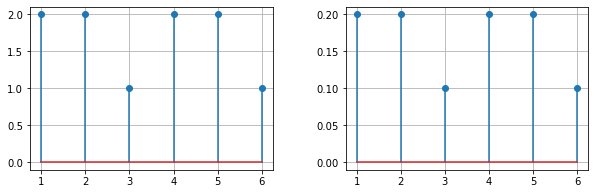

In [9]:
nsamples = 10  ###
results = np.random.randint(1, 7, size=nsamples)
numbers, counts = np.unique(results, return_counts=True)
frequences = counts/nsamples
np.set_printoptions(suppress=True)
print(np.c_[numbers, counts, frequences].T)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.stem(numbers, counts)
plt.subplot(1,2,2)
plt.stem(numbers, frequences)
plt.show()

**_Úkoly_**
- **zamyslete se, co tabulka a grafy přesně zobrazují**
- **experimentujte s proměnnou *nsamples***

Odpovědi jsou jednoduché. Graf vlevo zobrazuje tzv. **absolutní četnosti** jednotlivých stran kostky. Graf vpravo potom **četnosti relativní**, neboli normované četnosti absolutní. Ty se sčítají do jedničky a odpovídají *pravděpodobnostem* jednotlivých stran. Čím vyrovnanější graf, tím férovější kostka. A protože *np.random.randint()* vzorkuje z rovnoměrného rozdělení, čím větší rozsah výběru (počet vzorků), tím vyrovnanější graf.

### Spotřeba vozidla

*Měříme na zkušebně spotřebu vozidla při daných podmínkách a ptáme se, jaká je "teoretická" spotřeba.*

Na takovou úlohu můžeme nahlížet jako na zjišťování hodnoty *spojité* veličiny prostřednictvím měření, jež jsou zatížena nepředvídatelnými chybami způsobenými nedokonalostí měřících podmínek nebo procesu. Celkem jednoduše bychom naměřili hromadu čísel a spočetli jejich průměr. A protože máme základy fyziky, zjistili bychom i směrodatnou odchylku (odmocninu rozptylu chyb měření).

In [10]:
spotreba = np.array([5.5, 5.4, 5.7, 5.6, 6.1, 5.9, 5.8, 6.0, 5.9]) ###
prumer = spotreba.mean()
std = spotreba.std()
print('Průměrná spotřeba: ({0:.1f}+-{1:.1f})l/100km'.format(prumer, std))

Průměrná spotřeba: (5.8+-0.2)l/100km


### To je všechno pěkné...jenže!

Uvedené příklady demonstrovaly klasický _frekventistický_ přístup k problému - zjistili jsme frekvence výskytu daných jevů a ty prohlásili za výsledek. Má to ale pár háčků:
- je ten výsledek jednoznačný?
- když se měnil počet pokusů (množství dat), měnilo se něco?
- a co když budu vědět, že např. moje mince měla při posledním zkoumání rozdělení pravděpodobností [0.6, 0.4]? Jak to zakomponovat?

Jednou z možných variant, jak se s těmito problémy popasovat, je vydat se cestou bayesovské statistiky (pravděpodobnosti, zpracování dat...)

# Bayesovská teorie - začínáme

## Data popisuje model

Pro popis dat (měření, pozorování) resp. jejich vlastností slouží *matematický model*. S prvními modely jsme se potkali už velmi záhy na základní škole, například v podobě vzorečku pro rychlost $v=s/t$ (fyzikální model). Stejně tak můžeme modelovat například hmotnost objektu na základě jeho opakovaného měření. V případě fyzikálního modelu víme, že jeho platnost není úplně stoprocentní, zvl. při vysokých rychlostech dochází k relativistickým jevům. Stejně tak hmotnost objektu nemusíme pokaždé naměřit stejně (přesně). Proto používáme statistiku (zvl. bayesovskou nebo frekventistickou) a v ní modely v podobě pravděpodobnostních distribucí.

### Mince
Vhodným modelem pro minci je Bernoulliho (též alternativní) rozdělení. Označíme-li $X=1$ jev, že padl rub, $X=0$ že padl líc a $\pi \in [0, 1]$ pravděpodobnost rubu, pak toto rozdělení je dáno pravděpodobností (probability mass function, pmf)

$$
f(X|\pi) = \pi^{x} (1-\pi)^{1-x}, \qquad x\in\{0, 1\},
$$

a píšeme, že $X\sim\mathcal{B}\textit{ernoulli}(\pi)$, někdy jen $X\sim\mathcal{B}\textit{er}(\pi)$ apod.

Schválně si zkuste dosadit za $x$ a uvidíte, že dostanete příslušnou pravděpodobnost. Toto rozdělení má *střední (též očekávanou) hodnotu* $\mathbb{E}[X] = \pi$, což je snadné dokázat, neboť v diskrétním případě

$$
\mathbb{E}[X] = \sum_i x_i f(x_i).
$$

(Všimněte si poněkud nekonzistentního zápisu - cílem je jednoduchost, předpokládá se elementární inteligence čtenáře.)

**V distribuci známe vše kromě $\pi$. Vhodný odhad jeho hodnoty je cílem našeho modelování.**

Budeme ještě chvilku pokračovat - mincí můžeme hodit nejen jednou, ale třeba $n$-krát s tím, že rub padne právě $k$-krát kde $k\leq n$. Hody jsou nezávislé, odpovídají $n$ Bernouliovským pokusům a můžeme je popsat jednoduše *binomickým rozdělením* náhodné veličiny $Y \sim \textit{binom}(n, \pi)$ s pravděpodobností danou

$$
f(Y=k|n, \pi) = \binom{n}{k}\pi^k (1-\pi)^{n-k}, \qquad \text{se střední hodnotou}\quad \mathbb{E}[Y] = n\pi.
$$

Následuje kód, který vykreslí binomické rozdělení pro nastavená $n$ a $p$. Mějme na paměti, že uvažujeme $Y=k$, tedy počet rubů, a tedy $k\in\{0, 1, \ldots, n\}$.

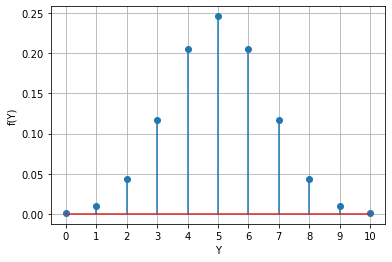

In [11]:
from scipy.stats import binom
n = 10                               ###
p = .5                               ###
ks = np.arange(0, n+1)
probs = binom.pmf(n=n, p=p, k=ks)
plt.stem(ks, probs)
plt.xticks(ks)
plt.xlabel('Y')
plt.ylabel('f(Y)')
plt.show()

**Úkoly**
- upravte předchozí kód tak, aby vykreslovat Bernoulliho rozdělení
- zamyslete se, proč může být střední hodnota neceločíselná.

### Kostka

Zatímco u mince mohou v jednom hodu nastat dva případy pro rub a líc (Bernoulliho rozdělení), u kostky jich je šest. Potřebujeme tedy něco na způsob "většího" binomického rozdělení, a tím je rozdělení *multinomické*. Označme tedy $x=[x_1,\ldots, x_k]$ vektor kde každé $x_i$ udává počet, kolikrát padla $i$-tá strana kostky. Pro $k$ stran kostky budeme mít $k$ pravděpodobností (jaký bude jejich součet?), které můžeme rovněž shrnout do vektoru $\pi=[\pi_1,\ldots,\pi_k]$. Pokusů bude podobně jako v binomickém případě $n\in\mathbb{N}_0$. Multinomické rozdělení $\mathcal{M}\textit{ulti}(n, \pi)$ má předpis

$$
f(X) = \frac{n!}{x_1! \cdots x_k!} \pi_1^{x_1} \cdots \pi_k^{x_k} \qquad\text{se střední hodnotou}\quad \mathbb{E}[X_i] = n\pi_i, \quad i\in\{1,\ldots,n\}.
$$

Tak, jako u binomického máme speciální případ $n=1$ nazývaný Bernoulliho (alternativní) rozdělení, zde tento případ nazýváme *kategorické* rozdělení, $\mathcal{C}\it{at}(\pi)$.

**Úkoly** (tentokrát ještě před příkladem)
- jaký musí být součet prvků vektoru $\pi$?
- chceme-li počítat pmf (viz níže) pro $n$ pokusů (hodů), jaký musí být součet prvků vektoru $x$?
- uvažujme $n = 1$, tedy jeden hod. Jaké budou hodnoty na grafu pmf?
- kolik bude různých kombinací výsledků hodu kostkou pro $n=2$ a pro $n=4$? To nám zároveň odpoví na otázku, zda jde rozumně vykreslovat pmf.

Zkusíme si vykreslit pmf pro $n = 1$, čimž si ověříme odpověď na jeden z úkolů.

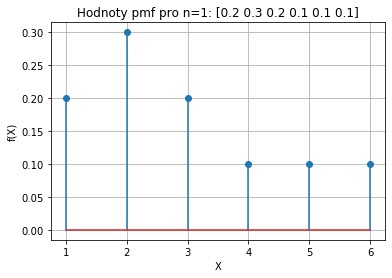

In [12]:
from scipy.stats import multinomial
n = 1                                        ###
pi = np.array([.2, .3, .2, .1, .1, .1])      ###
eye = np.eye(pi.size)                        ###
xis = np.arange(1, pi.size+1)
probs = multinomial.pmf(x=eye, n=n, p=pi)
plt.stem(xis, probs)
plt.xticks(xis)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.title("Hodnoty pmf pro n=1: {0}".format(probs))
plt.show()

Proměnná *eye* je jednotková matice. $k$-tý řádek tak říká, že padla právě $k$-tá strana kostky. Pro $n = 1$ - tedy jeden hod - jednoduché, že? Pro více hodů už nikoliv, viz další příklad, kde vykreslíme hodnoty pmf pro několik (*n_samples)* náhodně vybraných kombinací $n$ hodů.

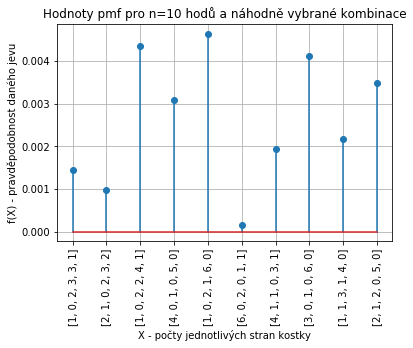

In [13]:
n = 10                                    ###
n_samples = 10                            ###
pi = np.array([.2, .05, .15, .1, .4, .1]) ###
xis = np.arange(1, pi.size+1)
rnd_samples = multinomial.rvs(n=n, p=pi, size=n_samples)
probs = multinomial.pmf(x=rnd_samples, n=n, p=pi)
plt.stem(probs)
plt.xticks(range(n_samples), [str(l) for l in rnd_samples.tolist()], rotation=90)
plt.xlabel('X - počty jednotlivých stran kostky')
plt.ylabel('f(X) - pravděpodobnost daného jevu')
plt.title("Hodnoty pmf pro n={0} hodů a náhodně vybrané kombinace".format(n))
plt.show()

### Spotřeba vozidla

Celkem logicky bychom předpokládali, že "průměrná" chyba je nulová (tj. nejde o chybu *systematickou*) a je symetricky rozložena vpravo i vlevo od nuly. Označme tedy hodnotu neznámé a odhadované teoretické spotřeby $\mu$. Naše nepřesná měření s oblibou popisujeme jako *normálně* rozdělenou náhodnou veličinu $X\sim\mathcal{N}(\mu, \sigma^2)$ s *hustotou pravděpodobnosti*

$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-1}{2\sigma^2}(x-\mu)^2},
$$

kde $x\in\mathbb{R}$, $\sigma^2>0$ je rozptyl a $\mu\in\mathbb{R}$ je střední hodnota normálního rozdělení. Pro střední hodnotu platí $\mathbb{E}[X]=\mu$.

Pokud se tedy rozhodneme modelovat spotřebu vozidla jako normálně rozdělenou veličinu, např. se střední hodnotou $\mu=5.5$ a směrodatnou odchylkou $\sigma=0.3$ - tedy rozptylem $\sigma^2=0.09$, bude graf hustoty pravděpodobnosti vypadat následovně:

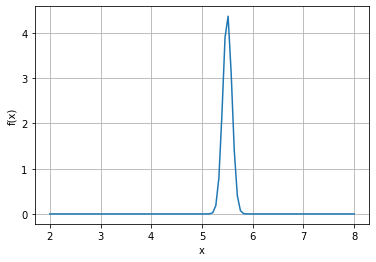

In [14]:
from scipy.stats import norm
mu = 5.5                   ###
std = .09                  ### pozor, zadava se smerodatna odchylka!
x = np.linspace(2, 8, 100)
fx = norm.pdf(x, loc=mu, scale=std)
plt.plot(x, fx)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Ač se to podle předpisu hustoty normálního rozdělení může zdát divné, výhodou rozdělení jsou poměrně snadné výpočty, často analyticky řešitelné. Na druhou stranu, toto rozdělení je - stejně jako většina jiných - v nejlepším případě slušnou aproximací reality. Používá se na popis rozdělení inteligenčního kvocientu, chyb měření ve fyzikálních experimentech, v hydrologii, radarech, často jako aproximace jiných, výpočtně náročnějších rozdělení.

**Úkoly:**
- IQ rozdělení se uvažuje centrované na hodnotě $\mu=100$ se směrodatnou odchylkou $\sigma=15$. Je poměrně jednoduché určit, že např. v intervalu $[\mu-\sigma, \mu+\sigma]$ leží 68.2% populace atd. Normální rozdělení má nosič (support, část definičního oboru kde je hustota nenulová) celou reálnou osu. Vyplývá z toho něco postrádajícího smysl?
- připomeňte si z teorie pravděpodobnosti (statistiky), zda hodnota hustoty pravděpodobnosti v libovolném bodě definičního oboru udává *pravděpodobnost* dané hodnoty či nikoliv.
- Součet všech hodnot pravděpodobnostní funkce diskrétní veličiny je jedna. Existuje nějaký ekvivalent pro hustotu pravděpodobnosti?
- Může hustota pravděpodobnosti nabývat hodnoty vyšší než jedna? Může pravděpodobnostní funkce nabývat hodnoty vyšší než jedna?

## Apriorní znalost

**Apriorní znalost je počáteční znalost o studované proměnné před zohledněním dat (pozorování, měření...).**

**Příklad s mincí:** Označme X stranu mince (např. panna) a kvantifikujme pravděpodobnost, že padne, tedy p(X). Můžeme například vycházet tvrdit, že o takové pravděpodobnosti nevíme vůbec nic, kromě toho, že je od 0 do 1 - případ (A). Alternativně můžeme předpokládat, že je pravděpodobně koncentrována kolem hodnoty 0.5 - případ (B1) a (B2). Za povšimnutí stojí, že i první případ má střední hodnotu 0.5, ale ta je stejně pravděpodobná, jako všechny ostatní, zatímco u (B1) a (B2) jsou hodnoty více a ještě více koncentrovány. A nebo můžeme předpokládat, že mince není úplně férová a čekáme, že panna padá častěji - případ (C). Mohli bychom najít spoustu jiných případů, např. degenerovanou variantu od (B1) resp. (B2) - Diracovu distribuci shrnující celou pravděpodobnost do jediného bodu.
![Apriorna u mince](img/l1-prior-mince.jpg)

Pozn.: ano, opravdu kvantifikujeme pravděpodobnost pravděpodobnosti :-) Používáme k tomu oblíbenou [beta distribuci](https://en.wikipedia.org/wiki/Beta_distribution) (bohužel zde si autor spletl encyklopedii s knihou).


**Příklad s kostkou, na první pokus:** Máme-li kvantifikovat náš odhad rozdělení pravděpodobností jednotlivých stran kostky, aniž bychom s ní jedinkrát hodili, s největší pravděpodobností budeme předpokládat, že je rovnoměrné, tj. každá strana je stejně pravděpodobná. To je varianta (A), tzv. férová kostka. Pokud ale hrajeme s nějakým koumákem a ten má kostku vlastní, můžeme dopředu přepokládat, že ta nebude zrovna férová, ale šestka bude výrazně pravděpodobnější - varianta (B). A do třetice můžeme jednotlivým stranám přidělit pravděpodobnosti nějak náhodně - varianta (C).
![Apriorna u kostky](img/l1-prior-kostka.jpg)

**Příklad s kostkou, na druhý pokus:** Povšimněme si jedné důležité věci - náš první pokus vůbec neříká, jak moc velká *neurčitost* je v těch pravděpodobnostech schována! Přitom u mince je *neurčitost* v apriornu obsažena! Jedna z možných (a současně nejobvyklejší) cesta je vyjádřit každou stranu zvlášť - podobně jako u mince - pravděpodobnost že padne a že nepadne. Kdybychom to shrnuli jednou funkcí, půjde o vyboulenou plochu v šestirozměrném prostoru, kterou bohužel nedokážeme nakreslit, a každý bod na této ploše odpovídá vektoru pravděpodobností se součtem 1. A odpovídající distribuce se jmenuje [Dirichletova](https://en.wikipedia.org/wiki/Dirichlet_distribution).

**Jak je zřejmé, apriorní znalost vyjadřujeme tzv. _apriorní distribucí_, kterou je buď pravděpodobnost (v diskrétním případě), nebo hustota pravděpodobnosti (ve spojitém případě). Měli-li bychom znalosti teorie míry, mohli bychom mluvit o hustotě psti v obou případech :-)**

**_Apriorní_ znalost (distribuce) přejde zahrnutím nových informací v _aposteriorní_. Obě kvantifikují míru _neurčitosti_ v naší znalosti o odhadovaném parametru.**

## Malá vzpomínka na teorii pravděpodobnosti

1. [Hustota pravděpodobnosti](https://en.wikipedia.org/wiki/Probability_density_function) nebo pravděpodobnostní funkce pro spojitou nebo diskrétní veličinu nám - velmi velmi vágně řečeno - udává, jak je pravděpodobnost realizace jednotlivých hodnot rozdělena. Slušná [definice](...) vyžaduje znalost teorie míry.
2. Je-li $f(x)$ hustota psti, pak $\int_X f(x)dx = 1$, kde integrujeme přes celý obor $X$. Analogicky, v diskrétním případě nahrazujeme hustotu pravděpodobnostní a integrál sumou a dostaneme opět 1. Kdybychom znali teorii míry, vystačíme si s integrálem.
3. [Střední hodnotou](https://en.wikipedia.org/wiki/Expected_value) náhodné veličiny $X$ nazýváme $\mathbb{E}[X] = \int x f(x) dx$ resp. $\mathbb{E}[X]= \sum_i x_i p_i$ kde $x_i$ jsou realizace a $p_i$ jejich pravděpodobnosti.
4. [Rozptylem](https://en.wikipedia.org/wiki/Variance) náhodné veličiny $X$ nazýváme $D[X] = \text{var} X = \int (x - \mathbb{E}[X])^2 f(x) dx$ resp. $D[X] = \text{var} X = \sum_i (x - \mathbb{E}[X])^2 p_i$. Ze vzorečku vidíme, že rozptyl udává míru disperze veličiny okolo střední hodnoty.
5. Střední hodnota ani rozptyl nemusejí existovat. Nenechte se zmást tím, že střední hodnotu bychom čekali uprostřed distribuce, např. u [Cauchyho distribuce](https://en.wikipedia.org/wiki/Cauchy_distribution) v obrázku níže. Jde o existenci integrálu.
6. Zajímat nás může rovněž modus (nejčetnější hodnota) a medián (prostřední hodnota). U některých rozdělení leží střední hodnota, modus i medián v jednom bodě ([normální rozdělení](https://en.wikipedia.org/wiki/Normal_distribution)), popř. modus a medián v jednom bodě ([Cauchyho rozdělení](https://en.wikipedia.org/wiki/Cauchy_distribution)), a nebo se jejich polohy mohou úplně lišit ([gama rozdělení](https://en.wikipedia.org/wiki/Gamma_distribution)).
  ![Distribuce](img/l1-distribuce.jpg)
7. Vícerozměrné distribuce, např. pro veličiny $X$ a $Y$ mají vícerozměrné hustoty nebo pravděpodobnosti  $f(x, y) = f(y, x)$ (na pořadí nezáleží). Rozlišujeme dále hustoty (nebo pravděpodobnosti) **marginální** $f(x)$ a $f(y)$ a **podmíněné** $f(x|y)$ a $f(y|x)$ (příklad bude níže). Důležité budou operace:
  - **Marginalizace:** $f(x) = \int f(x, y) dy$, analogicky se sumou pro diskrétní veličiny.
  - **Řetězové pravidlo:** $f(x, y) = f(x|y)f(y) = f(y|x) f(x)$.
  

### Příklad - dvourozměrné normální rozdělení
Uvažujme dvojrozměrný náhodný vektor $X = [X_1, X_2] \sim \mathcal{N}(\mu, \Sigma)$, kde $\mu = [\mu_1, \mu_2]$ je **vektor středních hodnot** a $\Sigma \in \mathbb{R}^{2\times 2}$ je symetrická pozitivně definitní **kovarianční matice**. Hustota pravděpodobnosti má předpis
$$
f(x) = \frac{1}{\sqrt{(2\pi)^{2}|\Sigma|}} \exp \left(-\frac{1}{2} (x-\mu)^\intercal \Sigma^{-1} (x-\mu) \right),
$$

kde $|\Sigma|$ je determinant kovarianční matice. Pro obecný případ $X\in\mathbb{R}^{k}$ má kovarianční matice rozměr $k \times k$ a v odmocnině je $(2\pi)^k$ namísto kvadrátu.

Následující obrázky ukazují prostorový graf a kontury hustoty pravděpodobnosti pro dvourozměrná normální rozdělení centrovaná v nule a s kovariancemi uvedenými nad horními grafy. Je zřejmé, že diagonální prvky udávají rozptyl pro danou složku vektoru a mimodiagonální udávají vzájemnou korelaci (natočení).
![Graf hustoty](img/l1-2dgauss-surface.jpg)
![Kontury hustoty](img/l1-2dgauss-contour.jpg)

### Příklad na marginální a podmíněné psti
Uvažujeme strojové rozpoznávání textu v závislosti na světelných podmínkách. To můžeme popsat podmíněnou pravděpodobností $P(R|S)$, kde R zastupuje "rozpoznání" a S "světelné podmínky". To je vlastně **model** pro R v závislosti na S. Zapišme pomocí tabulky:

R\S| Dobré | Přijatelné | Špatné |
--- | :---: | :---: | :---:
Rozpoznáno | 0.99 | 0.6 | 0.3 |
Nerozpoznáno | 0.01 | 0.4 | 0.7 |

Uvažujme dále, že pravděpodobnost světelných podmínek $P(S)$ - tedy marginální pst - je rozdělena takto:

S | Dobré | Přijatelné | Špatné |
--- | :---: | :---: | :---: |
$P(S)$ | 0.6 | 0.3 | 0.1 |

Potom pro sdružené pravděpodobnosti dostaneme:

R \ S | Dobré | Přijatelné | Špatné | $P(R)$
--- | :---: | :---: | :---: | :---:
Rozpoznáno | 0.594 | 0.18 | 0.03 | 0.804
Nerozpoznáno | 0.006 | 0.12 | 0.07 | 0.196
$P(S)$ | 0.6 | 0.3 | 0.1 | 1

Marginály jsme získali prostým vysčítáním v řádcích resp. sloupcích. Analogicky to funguje u spojitých veličin, akorát sumu nahradí integrál.

## Bayesova věta
$$
p(\theta|x) = \frac{f(x|\theta) p(\theta)}{f(x)}, \qquad f(x) > 0,
$$
kde $x$ a $\theta$ jsou (náhodné) veličiny a
- $p(\theta|x)$ je **aposteriorní** podmíněná pravděpodobnost (rozdělení psti) $X$
- $p(\theta)$ je **apriorní** pravděpodobnost (rozdělení psti)
- $f(x|\theta)$ je model nebo též věrohodnost (likelihood) dat,
- $f(x)$ je marginální pravděpodobnost $x$, též normovací faktor nebo anglicky `evidence'.

Jelikož jmenovatel je jen normalizační faktor nezávislý na odhadovaném $\theta$ a dostaneme jej jednoduše vysčítáním nebo integrací čitatele, $f(x) = \int f(x|\theta) p(\theta) d\theta$, zapisujeme často jen **proporcionalitu**
$$
p(\theta|x) \propto f(x|\theta) p(\theta).
$$

### Příklad
Zdroj: [Gelman et al.: Bayesian Data Analysis](https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954/)

[Hemofilie](https://cs.wikipedia.org/wiki/Hemofilie) (porucha srážlivosti krve) je dědičné onemocnění vázané na vadu alely chromozomu X. 
- Muži mají chromozomy XY, onemocnění propuká, je-li postižen příslušný chromozom X.
- Ženy mají chromozomy XX, onemocnění propuká a je fatální, pokud jsou současně pozitivní oba chromozomy.

**Případ: Žena, jejíž bratr je hemofilik, otec nikoliv. Je nosičem vadného chromozomu?**

**Řešení:**
- zdrojem vadného chromozomu by mohla být matka.
- **apriorní pravděpodobnost** stanovme rovnoměrnou: $Pr(\theta = 1) = Pr(\theta = 0) = \frac{1}{2}$.
- **model** na základě vyšetření dvou synů $y_1, y_2$ (oba negativní) uvažované ženy: $Pr(y_1, y_2|\theta)$
- můžeme postupovat graficky pomocí **rozhodovacího stromu**:
![Rozhodovací strom](img/l1-strom.jpg)
- aposteriorní pst že žena je nosičem vadného genu:
$$
Pr(\theta=1|y_1, y_2) = \frac
{Pr(y_1, y_2|\theta=1) Pr(\theta=1)}
{Pr(y_1, y_2|\theta=1) Pr(\theta=1) + Pr(y_1, y_2|\theta=0)Pr(\theta=0)}
= \frac
{\left(\frac{1}{2}\cdot \frac{1}{2}\right) \cdot \left( \frac{1}{2} \right)}
{\left(\frac{1}{2}\cdot \frac{1}{2}\right) \cdot \left( \frac{1}{2} \right) + (1 \cdot 1)\cdot\left(\frac{1}{2}\right)}
= \frac{1}{5}.
$$

- Sekvenční analýza: uvažujme třetího syna s negativní diagnozou $y_3 = 0$ a aktualizujme pravděpodobnosti. Použijeme výsledek z předchozích výpočtů a Bayesovu větu:
$$
Pr(\theta=1|y_1, y_2, y_3) \propto Pr(y_3|\theta, y_1, y_2) Pr(\theta|y_1, y_2)
= \frac
{\left( \frac{1}{2}\right) \cdot \left(\frac{1}{5}\right)}
{\left( \frac{1}{2}\right) \cdot \left(\frac{1}{5}\right) + (1) \cdot \left( \frac{4}{5} \right) }
= \frac{1}{9}.
$$

Vidíme, že s novými daty se naše informace zpřesňuje. Navíc nemusíme přepočítávat přes všechna data, neboť ta již máme v aposteriorní pravděpodobnosti z prvních dvou, a tu můžeme využít jako apriorno pro nový odhad.

### Příklad s mincí naposledy :-)

Vraťme se k příkladu s mincí a odhadováním pravděpodobnosti $\pi$, že padne rub, tedy jevu $X=1$. Z [přednášky](#link-mince) už víme, že $X$ můžeme popsat Bernoulliho (1 hod) nebo ještě lépe binomickým rozdělením popisujícím počet rubů v $n$ hodech. Máme tedy $X \sim binom(n, \pi)$ a tedy

$$
f(X=k|\pi, n) = \binom{n}{k}\pi^k (1-\pi)^{n-k}.
$$

Jak jsme již rovněž zmínili, vhodná apriorní distribuce pro pravděpodobnost $\pi\in[0, 1]$ může být beta distribuce s dvěma reálnými kladnými parametry, $\pi\sim\beta(a, b)$. Ta má hustotu pravděpodobnosti a střední hodnotu

$$
p(\pi|a, b) = \frac{1}{B(a, b)} \pi^{a-1} (1-\pi)^{b-1} 
\qquad\text{a}\quad
\mathbb{E}[\pi] = \mathbb{E}[\pi|a,b] = \frac{a}{a+b},
\qquad \text{a kde}\qquad 
B(a, b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}
$$

je [beta](https://en.wikipedia.org/wiki/Beta_function) funkce (to je speciální funkce, stejně jako v ní obsažené [gama](https://en.wikipedia.org/wiki/Gamma_function) funkce). K tomu ještě později.

Pomocí Bayesovy věty odvoďme aposteriorní distribuci:

$$
\begin{aligned}
p(\pi|a_0, b_0, x, n)
&\propto f(x|\pi, n) \cdot p(\pi|a, b) \\
&\propto \pi^k (1-\pi)^{n-k} \cdot \pi^{a-1} (1-\pi)^{b-1} \\
&\propto \pi^{a-1+k} (1-\pi)^{b-1+n-k} \\
&\propto \pi^{a_1-1} (1-\pi)^{b_1-1} \\
&= p(\pi|a_1, b_1), \qquad \text{kde $a_1 = a+k,\quad b_1 = b+n-k$.}
\end{aligned}
$$

Z poslední úpravy plyne, že **aposteriorní distribuce je rovněž beta distribuce**, tentokrát s parametry $a_1$ a $b_1$, tedy $\pi|n,k \sim \beta(a_1, b_1)$, přičemž v prvním je obsažen počet rubů a v druhém počet líců! Shrňme si pár poznatků:
- Vůbec jsme neoperovali s binomickým členem binomického rozdělení, ani s beta funkcí beta rozdělení. To jsou ony normalizační konstanty, které často (naštěstí) nemusíme řešit.
- Výpočet aposteriorní hustoty jsme zvládli snadno analyticky! To jde pro určitou třídu distribucí - tzv. **konjugovaných apriorních distribucí** vždy. Ovšem konjugovanost je v praxi spíše výjimkou. Často musíme sáhnout k aproximačním metodám typu Monte Carlo nebo variačním metodám.
- Celý výpočet aposteriorna je při konjugovaném apriornu jen přičítáním něčeho k apriorním hyperparametrům.
- Pro přidání nových dat použijeme $a_1, b_1$ jako apriorní distribuci a dostaneme $a_2, b_2$.
- Jako aposteriorní bodový odhad můžeme použít lecos, např. uvedená střední hodnota $\mathbb{E}[\pi|a_1,b_1] = \frac{a_1}{a_1+b_1}$ nebo medián $\tilde{\pi} \approx \frac{a_1-1/3}{a_1+b_1-2/3}$, nebo modus $\hat\pi = \frac{a_1-1}{a_1+b_1-2}$.
- Míru nejistoty spjatou s bodovým odhadem často vyjadřujeme rozptylem, zde $\text{var}\pi = \frac{a_1 b_1}{(a_1 + b_1)^2(a_1+b_1+1)}$. 

Následující grafy ukazují vývoj hustoty pravděpodobnosti beta rozdělení při 9 experimentech. V každém bylo 8x hozeno kostkou ($n=8$) a spočítány ruby ($k$) a líce ($n-k$). Apriorní beta rozdělení mělo hyperparametry $a=b=1$. V grafech je zobrazen vývoj hyperparametrů, střední hodnota a rozptyl, červeně je vykreslena středni hodnota. První graf je graf počátečního apriorna. Osa y je společná pro všechny grafy. Pro úplnost dodejme, že data byla generována z binomického rozdělení a odhadovaný parametr $\pi$ měl nastavenu hodnotu 0.7, okolo níž by se hustota měla postupně koncentrovat.
![Vývoj hustoty](img/l1-beta-mince.jpg)